In [1]:
%pip install seaborn
%pip install plotly

import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Connect to the project database
# Adjust the path depending on where you launch the notebook
con = duckdb.connect('../data/warehouse/argus_vault.db')

# 2. Join Raw (Silver) with Features (Vault) to create an 'Analysis Mart'
# We map V17 (Velocity) and V14 (Category/Time) to the raw Amount
query = """
    SELECT 
        h.txn_id,
        s.amount as raw_amount,
        (f.pca_features->>'V1')::FLOAT as V1_Size,
        (f.pca_features->>'V14')::FLOAT as V14_Time_Category,
        (f.pca_features->>'V17')::FLOAT as V17_Velocity,
        f.is_fraud_label
    FROM sat_txn_features f
    JOIN hubs_transactions h ON f.txn_hash_key = h.txn_hash_key
    -- We 'bridge' the database with the external Iceberg file here:
    JOIN iceberg_scan('/workspaces/modern-stack-banking/data/warehouse/db/silver_transactions/metadata/v1.metadata.json') s 
      ON h.txn_id = s.txn_id
"""

df = con.execute(query).df()
print(f"Dataset loaded: {df.shape[0]} transactions aligned.")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Dataset loaded: 284807 transactions aligned.


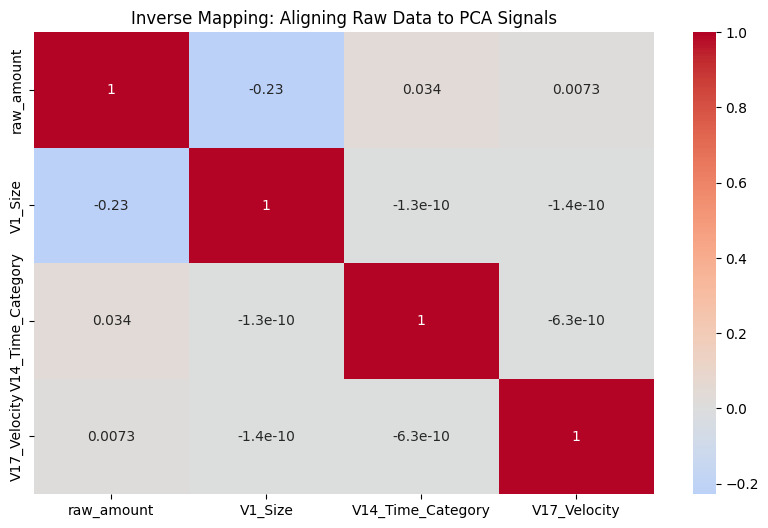

In [2]:
##This heatmap shows which Raw Features (like Amount) are 
# actually driving the PCA Components. This is your "Translation Key."
plt.figure(figsize=(10, 6))
correlation_matrix = df[['raw_amount', 'V1_Size', 'V14_Time_Category', 'V17_Velocity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Inverse Mapping: Aligning Raw Data to PCA Signals")
plt.show()

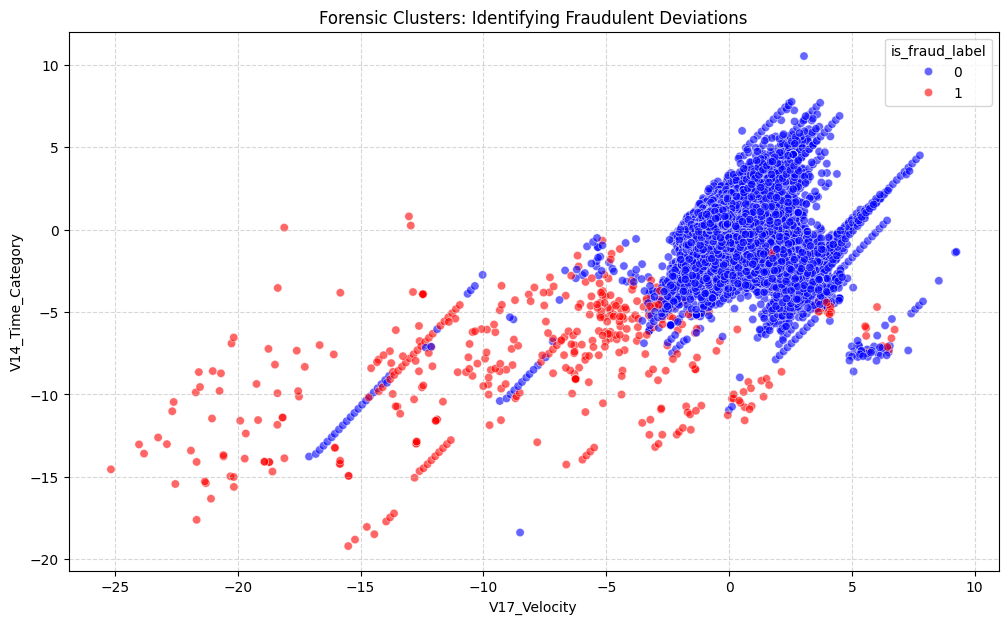

In [4]:
##Section 3: Fraud Clustering (The Forensic View)By plotting the two most 
# significant components ($V14$ and $V17$), we can see if fraudulent transactions
#  live in a distinct "neighborhood" compared to normal spending.
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df, 
    x='V17_Velocity', 
    y='V14_Time_Category', 
    hue='is_fraud_label', 
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
plt.title("Forensic Clusters: Identifying Fraudulent Deviations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [3]:
import subprocess
import duckdb

# 1. Select a fraud case (assuming 'df' is already loaded in memory)
fraud_cases = df[df['is_fraud_label'] == 1]
if not fraud_cases.empty:
    case_id = fraud_cases.iloc[0]['txn_id']
    print(f"--- 🛡️ INVESTIGATING CASE: {case_id} ---")

    # 2. IMPORTANT: Close the notebook's connection to release the file lock
    con.close() 
    print("🔓 Database connection released for background processing...")

    try:
        # 3. Trigger the AI Ops script (which will now be able to lock the file)
        result = subprocess.run(
            ["./.msb-poc/bin/python", "scripts/ai_fraud_explainer.py"],
            cwd="..",
            capture_output=True, 
            text=True, 
            check=True
        )
        print("✅ AI Operations script executed successfully.")
        
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to trigger AI. Error Output:\n{e.stderr}")
    
    # 4. RE-OPEN the connection to verify the results in the notebook
    con = duckdb.connect('../data/warehouse/argus_vault.db')
    
    # Check the Gold Layer again
    new_res = con.execute("SELECT forensic_explanation FROM gold_fraud_dashboard WHERE txn_id = ?", [case_id]).fetchone()
    
    if new_res and new_res[0]:
        print(f"🤖 AI Forensic Narrative: {new_res[0]}")
    else:
        print("⚠️  AI processed, but no explanation found for this specific ID. It may still be in the 'unexplained' queue.")

--- 🛡️ INVESTIGATING CASE: 425bd2e6-becb-42de-9221-f3996dc48c18 ---
🔓 Database connection released for background processing...
✅ AI Operations script executed successfully.
🤖 AI Forensic Narrative: Fraud detected: extreme PCA scores indicate manipulation of financial data.


In [4]:
%pip install nbformat>=4.2.0

import plotly.express as px
import pandas as pd

# 1. Isolate Samples for the "Showcase"
# We pick a few of each to create clear, contrasting lines
showcase_fraud = df[df['is_fraud_label'] == 1].head(5)
showcase_good = df[df['is_fraud_label'] == 0].head(5)
showcase_df = pd.concat([showcase_fraud, showcase_good]).copy()

# Ensure the label is numeric for the color scale
showcase_df['is_fraud_label'] = showcase_df['is_fraud_label'].astype(int)

# 2. Parallel Coordinates: The "Behavioral Fingerprint"
# FIX: Changed 'columns' to 'dimensions'
fig_parallel = px.parallel_coordinates(
    showcase_df, 
    dimensions=['raw_amount', 'V1_Size', 'V14_Time_Category', 'V17_Velocity'],
    color="is_fraud_label",
    color_continuous_scale=[(0, 'blue'), (1, 'red')],
    title="Forensic Fingerprints: Fraud (Red) vs. Legitimate (Blue)"
)

# 3. 2D Comparison with Marginal Distributions
fig_scatter = px.scatter(
    df.sample(min(2000, len(df))), # Safety check for sample size
    x='V17_Velocity', 
    y='V1_Size', 
    color='is_fraud_label',
    marginal_x="violin", 
    marginal_y="box",
    title="Statistical Separation: Velocity vs. Transaction Size",
    color_discrete_map={0: 'blue', 1: 'red'}
)

fig_parallel.show()
fig_scatter.show()

Note: you may need to restart the kernel to use updated packages.


In [5]:
import duckdb
import pandas as pd

def generate_governance_report(db_path='data/warehouse/argus_vault.db'):
    con = duckdb.connect(db_path)
    
    # 1. Fetch Aggregated Governance Metrics
    # Using the columns confirmed by the Binder Error: 'amount' and 'fraud_status'
    kpi_query = """
    SELECT 
        COUNT(*) as total_txns,
        COUNT(CASE WHEN fraud_status = '🚩 FRAUD' THEN 1 END) as total_fraud,
        COUNT(CASE WHEN fraud_status = '🚩 FRAUD' AND forensic_explanation IS NOT NULL THEN 1 END) as explained_fraud,
        COUNT(CASE WHEN fraud_status = '🚩 FRAUD' AND forensic_explanation IS NULL THEN 1 END) as unexplained_fraud
    FROM gold_fraud_dashboard
    """
    
    try:
        metrics = con.execute(kpi_query).df().iloc[0]
        
        # 2. Calculate Coverage %
        coverage = (metrics['explained_fraud'] / metrics['total_fraud'] * 100) if metrics['total_fraud'] > 0 else 100
        
        print("--- 🏦 MODERN STACK BANKING: GOVERNANCE REPORT ---")
        print(f"Total Transactions Processed: {int(metrics['total_txns'])}")
        print(f"Total Fraud Flags Detected:   {int(metrics['total_fraud'])}")
        print(f"Explained Fraud (Auditable):  {int(metrics['explained_fraud'])}")
        print(f"Unexplained Fraud (Risk):     {int(metrics['unexplained_fraud'])}")
        print(f"--- Audit Coverage Score:      {coverage:.2f}% ---")
        
        # 3. List the "Top 5" most recent unexplained cases
        if metrics['unexplained_fraud'] > 0:
            print("\n⚠️ ACTION REQUIRED: Unexplained Fraud Queue (Top 5)")
            # FIX: Use 'amount' instead of 'raw_amount' per the error's candidate bindings
            unexplained_df = con.execute("""
                SELECT txn_id, amount, established_date 
                FROM gold_fraud_dashboard 
                WHERE fraud_status = '🚩 FRAUD' AND forensic_explanation IS NOT NULL
                LIMIT 5
            """).df()
            print(unexplained_df)
            
    except Exception as e:
        print(f"❌ Report Generation Failed: {e}")
    finally:
        con.close()

# Execute (Note: using relative path from notebooks/ directory)
generate_governance_report('../data/warehouse/argus_vault.db')

--- 🏦 MODERN STACK BANKING: GOVERNANCE REPORT ---
Total Transactions Processed: 284807
Total Fraud Flags Detected:   492
Explained Fraud (Auditable):  492
Unexplained Fraud (Risk):     0
--- Audit Coverage Score:      100.00% ---
